# Lab 5: A Black-Box Adversarial Attack
In this lab, we'll carry out an adversarial attack in the **black box** case: we don't have the weights of the network we're trying to trick (the **target model**), and instead we can only give it inputs and see its outputs.

Black-box adversarial attacks are based on the fact that adversarial examples are _transferable_: if it tricks one network, it will likely trick another (but less well).
So, since we need network weights to make adversarial examples, we train a second model, the **surrogate model**, to act like the target model.
To do this, we'll use the target model as an "oracle" to make a dataset where the features are from real examples, and the labels are the outputs of the target model on those examples.
If the surrogate model learns to output the same probabilities as the target model on a given input, its internal representations are likely similar.
Then, when we make an adversarial example for the surrogate model, it should also trick the target model.

The end result of this lab should be an image which looks close to some image in the dataset, but tricks the target network into assigning high confidence to some other class. 

## Section 0: Load the data
This uses the same dataset as last time, so just copy the data over here in the same format.
The same data loading and preprocessing as before is in place.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Seed numpy rng for reproducibility
np.random.seed(1337)

# Load data
x_all = np.load('data/X.npy')
y_all = np.load('data/Y.npy')

# Maps dataset-provided label to true label
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

# Correct dataset labels
for row in range(y_all.shape[0]):
    dataset_label = np.where(y_all[row])[0][0]
    y_all[row, :] = np.zeros(10)
    y_all[row, label_map[dataset_label]] = 1
    
# Shuffle features and targets together
# Credit for this technique to:
# https://stackoverflow.com/questions/4601373/
# better-way-to-shuffle-two-numpy-arrays-in-unison
rng_state = np.random.get_state()
np.random.shuffle(x_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

# Add a dummy channel axis to input images
x_all = np.expand_dims(x_all, axis=-1)

# Center and rescale data to the range [-1, 1]
x_all = x_all - 0.5
x_all = x_all * 2

# Create a validation set from 30% of the available data
n_points = x_all.shape[0]
n_test = int(n_points * 0.3)
n_train = n_points - n_test
x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train], axis=0)

In [3]:
x_all.shape

(2062, 64, 64, 1)

## Section 1: Train the black-box model
Below, I've written a CNN in Keras to classify images from the dataset, and the code to train it.
This will act as the "black box model."

Train the model using the code below.
It should hit about 95-96% validation accuracy on the dataset.

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D

inputs = Input(shape=(64, 64, 1))
layer = Conv2D(16, 5, strides=(2, 2), activation='relu')(inputs)
layer = Conv2D(16, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(32, 3, activation='relu')(layer)
layer = Conv2D(32, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
probs = Dense(10, activation='softmax')(layer)

target_model = Model(inputs, probs)
target_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_

Using TensorFlow backend.


In [5]:
from keras.optimizers import Adam

opt = Adam(1e-3)
target_model.compile(opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
target_model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=15)

Instructions for updating:
Use tf.cast instead.
Train on 1444 samples, validate on 618 samples
Epoch 1/15
1444/1444 [==============================] - 3s 2ms/step - loss: 2.0512 - acc: 0.2507 - val_loss: 1.3017 - val_acc: 0.5761
Epoch 2/15
1444/1444 [==============================] - 3s 2ms/step - loss: 0.8818 - acc: 0.7091 - val_loss: 0.5658 - val_acc: 0.8172
Epoch 3/15
1444/1444 [==============================] - 3s 2ms/step - loss: 0.5094 - acc: 0.8289 - val_loss: 0.4001 - val_acc: 0.8738
Epoch 4/15
1444/1444 [==============================] - 3s 2ms/step - loss: 0.3347 - acc: 0.8850 - val_loss: 0.4409 - val_acc: 0.8560
Epoch 5/15
1444/1444 [==============================] - 2s 2ms/step - loss: 0.2363 - acc: 0.9211 - val_loss: 0.2824 - val_acc: 0.9159
Epoch 6/15
1444/1444 [==============================] - 2s 2ms/step - loss: 0.1415 - acc: 0.9543 - val_loss: 0.2611 - val_acc: 0.9175
Epoch 7/15
1444/1444 [==============================] - 2s 2ms/step - loss: 0.1369 - acc: 0.9584 - va

## Section 2: Build an "oracle dataset" and data pipeline
Now, we'll treat the target model as a black box: pretend we don't have access to its weights or its original input data.
In the wild, all we can do is give it inputs and see its outputs.

We want to train a surrogate model to act similarly to the target model, so create a fake "oracle dataset" where the features are `x_all` and the outputs are the 10-vectors of probability the target model predicts for that input.

Then, set up any `tf.data.Dataset` and `tf.data.Iterator` objects you need.
In this case we don't have a test set, just a training set.

In [7]:
y_oracle = target_model.predict(x_all)

In [8]:
n_epochs = 15
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices((x_all, y_oracle))\
    .shuffle(500).batch(batch_size).cache()

In [9]:
iterator = tf.data.Iterator.from_structure(
    dataset_train.output_types, 
    dataset_train.output_shapes)

train_init_op = iterator.make_initializer(dataset_train)

## Section 3: Build a surrogate model
The surrogate model is designed to act similarly to the target model, so that adversarial examples we create for it will also work on the target model.
Feel free to use any architecture you want, but matching the target architecture closely (maybe with a bit more capacity) is a good bet.

Copy code from last week's assignment liberally.
Most likely, you won't have to write all that much new code in this section.

### 3.1: Input tensors
Get a tensor for the input image and another for the correct label.
Note that the label is already one-hot encoded.

In [10]:
with tf.name_scope('inputs'):
    next_elem = iterator.get_next()
    features = tf.identity(next_elem[0], name='features')
    digit = tf.identity(next_elem[1],name='digit')

### 3.2: Adversarial noise
This is the only part of the model that really differs from last week, and it's a bit tricky.

Add a variable to the graph that represents the adversarial noise we'll add to one example.
It should be the shape of a single input image and initialized to zeros.
In addition, pass (to `get_variable`) the keyword argument `constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3)`.
Every time the variable is updated, it will become the result of the lambda function, which in this case constrains its pixel values to be in the range -0.3 to 0.3.
(Equivalently, at every step we re-project the adversarial noise back into a hypercube at the origin with side length 0.6).
I found that 0.3 works well, but feel free to change this value -- smaller values will produce less obvious noise, while larger values will produce more successful attacks. 

Add a boolean `tf.placeholder_with_default()` (default False) named "use_noise" to the graph.
This will act as a "switch" controlling whether a given run uses adversarial noise.

Add a `tf.cond()` operation that, depending on "use_noise", switches between the input image and the image plus the adversarial noise.
This allows us to train the surrogate model without adversarial noise, then enable it when crafting the adversarial example.

Finally, add a summary histogram and a summary image for the adversarial noise tensor, so we can plot it as we're learning the adversarial example.
Also add a summary image for the output of `cond`, which will be our adversarial example later

In [11]:
noise = tf.get_variable('noise', shape=(1, 64, 64, 1), dtype=tf.float32,
                          initializer=tf.zeros_initializer(), 
                        constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3))

In [12]:
use_noise = tf.placeholder_with_default(False, shape=(), name='use_noise')

cond = tf.cond(use_noise, lambda: features + noise, lambda: features)

adv_noise_img = tf.summary.image('adversarial_noise', noise)
adv_noise_hist = tf.summary.histogram('adversarial_noise', noise)

cond_img = tf.summary.image('conditional', cond)

### 3.3: The rest of the model
Using the functions `make_dense_layer()` and `make_conv_layer()` you wrote last week, finish the graph of the surrogate model.
The only difference is that instead of using the input image, you should use the output of the `cond()` switch before, to allow adding adversarial noise.
Don't add the optimizer yet.

This should involve tensors that:
 - Act as hidden convolutional and dense layers
 - Compute the logits and probabilities for a batch of input images
 - Compute the predicted digit from the probabilities
 - Compute the mean cross-entropy loss over a batch

In [13]:
def make_dense_layer(prev_activations, dim_input, dim_output, 
                     do_activation=True, postfix=''):
    '''
    Adds a dense layer to the model graph.
    
    Parameters
    ----------
    prev_activations: tensor
        The activations of the previous layer, or 
        the input for the first dense layer.
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
        Equivalently, number of units in this layer.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    with tf.name_scope('dense' + postfix):
        with tf.variable_scope('dense' + postfix):
            weights = tf.get_variable('weights', shape=(dim_input, dim_output), dtype=tf.float32,
                          initializer=tf.initializers.he_uniform())
            bias = tf.get_variable('bias', shape=(dim_output), dtype=tf.float32, 
                                   initializer=tf.zeros_initializer())
        output = tf.matmul(prev_activations, weights) + bias
        if do_activation:
            output = tf.nn.relu(output)
        return output    

In [14]:
def make_conv_layer(input_, input_channels, n_filters,
                    filter_size=3, stride=1, 
                    do_activation=True, pool_size=1,
                    add_summary=False, postfix='', pad='SAME', max_pad='SAME'):
    '''
    Adds a convolutional layer to the model graph.
    
    Parameters
    ----------
    input_: tensor
        The activations of the previous layer, or 
        the input for the first dense layer.
    input_channels: int
        Number of channels in the input representation.
    n_filters: int
        Number of channels in the output representation.
        Equivalently, number of filters in this layer.
    filter_size: int
        Width and height of each kernel in the layer's filters.
    stride: int
        Stride to use in the x and y directions for the
        convolution operation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    pool_size: int
        If > 1, does max pooling of this size to the
        width and height axes of the activation.
    add_summary: bool
        Whether or not to log activations as summary images.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    with tf.name_scope('conv' + postfix):
        with tf.variable_scope('conv' + postfix):
            filters = tf.get_variable('filters', shape=(filter_size, filter_size, input_channels, 
                          n_filters), dtype=tf.float32, initializer=tf.initializers.he_uniform())
            biases = tf.get_variable('biases', shape=(1, 1, 1, n_filters), dtype=tf.float32, initializer=tf.zeros_initializer())
            
        output = tf.nn.conv2d(input_, filters, strides=[1,stride,stride,1], padding=pad) + biases
        if do_activation:
            output = tf.nn.relu(output)
        if add_summary:
            for i in range(n_filters):
                tf.summary.image('activation' + str(i), tf.expand_dims(output[:,:,:,i],-1))
        if pool_size > 1:
            output = tf.nn.max_pool(output, [1,pool_size,pool_size,1], [1,pool_size,pool_size,1], padding=max_pad)
        return output    
        

In [15]:
conv_1 = make_conv_layer(cond, 1, 16, pad='VALID', filter_size=5, stride=2, postfix='1')
conv_2 = make_conv_layer(conv_1, 16, 16, pad='VALID', pool_size=2, postfix='2')
conv_3 = make_conv_layer(conv_2, 16, 32, pad='VALID', postfix='3')
conv_4 = make_conv_layer(conv_3, 32, 32, pad='VALID', pool_size=2, postfix='4')
conv_5 = make_conv_layer(conv_4, 32, 64, postfix='5')
conv_6 = make_conv_layer(conv_5, 64, 64, pool_size=2, postfix='6', max_pad='VALID')
flatten = tf.reshape(conv_6, [-1, 256])
dense_1 = make_dense_layer(flatten, 256, 128, True, '1')
logits = make_dense_layer(dense_1, 128, 10, False, 'out')
probs = tf.nn.softmax(logits)


In [16]:
loss_per_example = tf.nn.softmax_cross_entropy_with_logits_v2(digit, logits)
loss_batch = tf.reduce_mean(loss_per_example)
tf.summary.scalar('loss', loss_batch)

<tf.Tensor 'loss_1:0' shape=() dtype=string>

In [17]:
pred = tf.argmax(probs, axis=1)
correct = tf.argmax(digit, axis=1)
num_correct = tf.reduce_sum(tf.cast(tf.equal(pred, correct), tf.float32))
accuracy = num_correct / tf.cast(tf.shape(probs)[0], tf.float32)

tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

### 3.4: Surrogate optimizer
Add an optimizer and update operation we'll use to train the surrogate model to act like the target model.
It should just minimize the cross-entropy loss between the model's predictions and the targets.

In [18]:
optimizer = tf.train.AdamOptimizer()
optimize_step = optimizer.minimize(loss_batch)

### 3.5: Adversarial loss
When training the surrogate model, we want to change the model parameters to minimize the loss.
When creating the adversarial example, we want to do something very different: _change the adversarial noise tensor alone to maximize the loss_.

So, define a new adversarial loss which is the negative of the original loss, and a new optimizer to minimize it.
When you call `minimize()`, pass in the keyword argument `var_list=[noise]`, where "noise" is the name of your adversarial noise tensor.
This will prevent the optimizer from changing the weights of the model when we optimize the adversarial noise.

Finally, add a summary scalar to plot the adversarial loss decreasing.

In [19]:
adversarial_loss = -loss_batch
optimizer_adv = tf.train.AdamOptimizer()
optimize_step_adv = optimizer.minimize(adversarial_loss, var_list=[noise])

tf.summary.scalar('adv_loss', adversarial_loss)

<tf.Tensor 'adv_loss:0' shape=() dtype=string>

## 4: Train the surrogate model
Train your surrogate model until it hits high accuracy.
At the very least it should have 90% accuracy -- I hit 98-100% on the training set.
Overfitting isn't really a concern here since we are actually trying to memorize the peculiarities of the target model.

When the training loop is done, save the model under `./checkpoints/model_surrogate.ckpt`.
We won't be modifying this particular checkpoint any more, it'll contain the fully-trained surrogate model with zero adversarial noise.

In [20]:
merged_summaries = tf.summary.merge_all()
saver = tf.train.Saver()

train_batch = 0

with tf.Session() as sess:
    # Make one writer for training logs and another for test logs 
    train_writer = tf.summary.FileWriter('./logs_lab/train', graph=sess.graph)
    test_writer = tf.summary.FileWriter('./logs_lab/test')
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Training loop
    for epoch in range(n_epochs):
        # Load training data
        sess.run(train_init_op)
        
        losses = []
        accuracies = []
        
        # Iterate over the dataset once
        while True:
            try:
                if train_batch > 0: # Typical batch
                    # Run summary ops and optimization
                    summary, loss, acc, _ = sess.run([merged_summaries, loss_batch, accuracy, optimize_step])
                    losses.append(loss)
                    accuracies.append(acc)
                    train_writer.add_summary(summary, train_batch)
                    train_batch += 1
                else:
                    # On the first batch, run a full trace
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    
                    summary, _ = sess.run([merged_summaries, optimize_step],
                                          options=run_options,
                                          run_metadata=run_metadata)
                    
                    train_writer.add_summary(summary, train_batch)    
                    train_writer.add_run_metadata(run_metadata, 
                                                  'first training batch')
                    train_batch += 1
            except tf.errors.OutOfRangeError: # No more data
                break
                
        print('Epoch:', epoch)
        average_loss = np.mean(losses)
        average_acc = np.mean(accuracies)
        print('Average loss:', average_loss)
        print('Average accuracy:', average_acc)
        
    # Save model
    saver.save(sess, './checkpoints/model_surrogate.ckpt')    

Epoch: 0
Average loss: 1.689477
Average accuracy: 0.417899
Epoch: 1
Average loss: 0.5238173
Average accuracy: 0.83585167
Epoch: 2
Average loss: 0.24811618
Average accuracy: 0.9226648
Epoch: 3
Average loss: 0.16363396
Average accuracy: 0.9565934
Epoch: 4
Average loss: 0.10437731
Average accuracy: 0.9774038
Epoch: 5
Average loss: 0.08028273
Average accuracy: 0.9879808
Epoch: 6
Average loss: 0.07479338
Average accuracy: 0.99182695
Epoch: 7
Average loss: 0.05754125
Average accuracy: 0.99375
Epoch: 8
Average loss: 0.059848383
Average accuracy: 0.99567306
Epoch: 9
Average loss: 0.06493696
Average accuracy: 0.9883242
Epoch: 10
Average loss: 0.05865464
Average accuracy: 0.9947115
Epoch: 11
Average loss: 0.06204449
Average accuracy: 0.99361265
Epoch: 12
Average loss: 0.05973729
Average accuracy: 0.9916896
Epoch: 13
Average loss: 0.070570424
Average accuracy: 0.99375
Epoch: 14
Average loss: 0.059516236
Average accuracy: 0.9913462


## 5. Learn the adversarial example
Finally, it's time to create an adversarial example using our surrogate model.
Pick an image from the test set (or use the one I picked below), then run a training loop to minimize the adversarial loss (equivalently, maximize the model loss on that example).
To do this, use `sess.run(..., feed_dict={pixels: [img], label: [lbl], use_noise: True})`.
This turns on the `use_noise` switch we set before, and overwrites the input image batch with a "batch" containing only the single image we're going to turn into an adversarial example.

At the start, load the checkpoint we saved before.
When it's done, save it to a new checkpoint, `./checkpoints/model_adversarial.ckpt`.
This new checkpoint should have exactly the same model parameters as before (remember that we're only optimizing the noise), but a nonzero noise tensor.

At the end, also save the adversarial example (which will be contained in the result of your `cond`) and the noise tensor to a numpy array so we can use them later.

Periodically write the image and histogram summaries so you can look at them in TensorBoard later.

Text(0.5,1,'True label: 9')

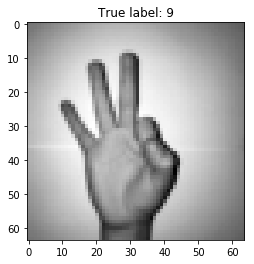

In [21]:
# Pick and plot the image we'll turn into an adversarial example
idx = 1
img = x_test[idx]
lbl = y_test[idx]

plt.imshow(img[:, :, 0], cmap='gray')
plt.title('True label: {}'.format(np.argmax(lbl)))

In [22]:
merged_summaries = tf.summary.merge_all()
saver = tf.train.Saver()
with tf.Session() as sess:
    # Make one writer for training logs and another for test logs 
    train_writer = tf.summary.FileWriter('./logs_lab/train', graph=sess.graph)
    saver.restore(sess, './checkpoints/model_surrogate.ckpt')
    
    # Training loop
    for epoch in range(100):
        # Load training data
        sess.run(train_init_op)
        summary, loss, acc, _ = sess.run([merged_summaries, loss_batch, accuracy, optimize_step_adv], feed_dict={features: [img], digit: [lbl], use_noise: True})
        train_writer.add_summary(summary, train_batch)
                
        print('Epoch:', epoch)
        print('loss:', loss)
        print('accuracy:', acc)
        
    adv_example = sess.run(cond, feed_dict={features: [img], digit: [lbl], use_noise: True})[0]
    noise_array = noise.eval()[0]
        
    # Save model
    saver.save(sess, './checkpoints/model_adversarial.ckpt')    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints/model_surrogate.ckpt
Epoch: 0
loss: 0.0037513853
accuracy: 1.0
Epoch: 1
loss: 0.0064511383
accuracy: 1.0
Epoch: 2
loss: 0.013235568
accuracy: 1.0
Epoch: 3
loss: 0.029652402
accuracy: 1.0
Epoch: 4
loss: 0.06523436
accuracy: 1.0
Epoch: 5
loss: 0.14446563
accuracy: 1.0
Epoch: 6
loss: 0.31480578
accuracy: 1.0
Epoch: 7
loss: 0.6282021
accuracy: 1.0
Epoch: 8
loss: 1.1542956
accuracy: 0.0
Epoch: 9
loss: 1.8962561
accuracy: 0.0
Epoch: 10
loss: 2.8123846
accuracy: 0.0
Epoch: 11
loss: 3.8206282
accuracy: 0.0
Epoch: 12
loss: 4.900335
accuracy: 0.0
Epoch: 13
loss: 5.9302545
accuracy: 0.0
Epoch: 14
loss: 6.9392705
accuracy: 0.0
Epoch: 15
loss: 7.925747
accuracy: 0.0
Epoch: 16
loss: 8.886602
accuracy: 0.0
Epoch: 17
loss: 9.757723
accuracy: 0.0
Epoch: 18
loss: 10.533549
accuracy: 0.0
Epoch: 19
loss: 11.240261
accuracy: 0.0
Epoch: 20
loss: 11.940318
accuracy: 0

## 6: Visualize the adversarial example
Plot the original example, the adversarial example, and the adversarial noise below.

(-0.5, 63.5, 63.5, -0.5)

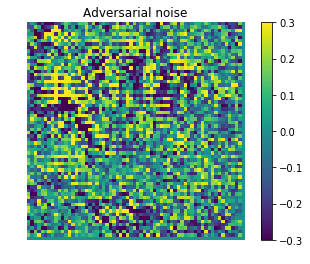

In [23]:
plt.imshow(noise_array[:, :, 0])
plt.title('Adversarial noise')
plt.colorbar()
plt.axis('off')

Text(0.5,1,'Image with Adversarial Noise')

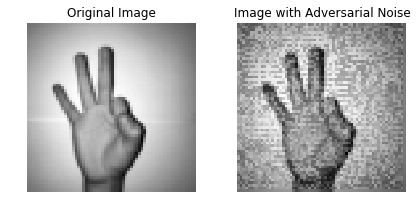

In [24]:
_, plots = plt.subplots(ncols=2)
plt.tight_layout()

 
plots[0].imshow(img[:, :, 0], cmap='gray')
plots[0].axis('off')
plots[0].set_title('Original Image')

plots[1].imshow(adv_example[:, :, 0], cmap='gray')
plots[1].axis('off')
plots[1].set_title('Image with Adversarial Noise')


## 7: Demonstrate that the surrogate model fails on the adversarial example
Compute the surrogate model's prediction and probability for the original example and the adversarial example, and compare them.

INFO:tensorflow:Restoring parameters from ./checkpoints/model_surrogate.ckpt


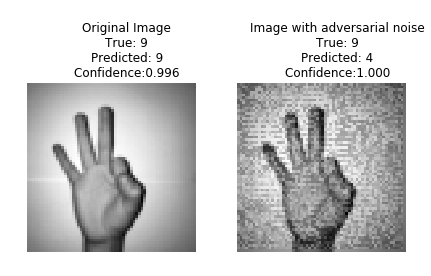

In [25]:
with tf.Session() as sess:
    _, plots = plt.subplots(ncols=2)
    plt.tight_layout()

    saver.restore(sess, './checkpoints/model_surrogate.ckpt')

    # Plot the model's predictions on the original image
    probs_np, pred_np = sess.run([probs, pred], feed_dict={features: [img]})
    confidence = np.max(probs_np)

    plots[0].imshow(img[:, :, 0], cmap='gray')
    plots[0].axis('off')
    plots[0].set_title(
        '''
        Original Image
        True: {0}
        Predicted: {1}
        Confidence:{2:0.3f}'''.format(np.argmax(lbl), pred_np[0], confidence))

    # Plot the model's predictions on the noised image
    probs_np, pred_np = sess.run([probs, pred], feed_dict={features: [adv_example]})
    confidence = np.max(probs_np)

    plots[1].imshow(adv_example[:, :, 0], cmap='gray')
    plots[1].axis('off')
    plots[1].set_title(
        '''
        Image with adversarial noise
        True: {0}
        Predicted: {1}
        Confidence:{2:0.3f}'''.format(np.argmax(lbl), pred_np[0], confidence))

## 8: Demonstrate that the target model fails on the adversarial example
This is the real test -- transferring the learned adversarial example from the surrogate model to the target model.
Compute the target model's prediction and probability for the original example and the adversarial example, and compare them.

Text(0.5,1,'\n    Image with adversarial noise\n    True: 9\n    Predicted: 4\n    Confidence:0.781')

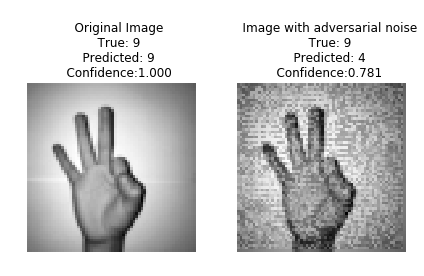

In [26]:
_, plots = plt.subplots(ncols=2)
plt.tight_layout()

# Plot the model's predictions on the original image
probs_t = target_model.predict(np.expand_dims(img, 0))[0]
pred_t = np.argmax(probs_t)
confidence = np.max(probs_t)

plots[0].imshow(img[:, :, 0], cmap='gray')
plots[0].axis('off')
plots[0].set_title(
    '''
    Original Image
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(np.argmax(lbl), pred_t, confidence))

# Plot the model's predictions on the noised image
probs_t = target_model.predict(np.expand_dims(adv_example, 0))[0]
pred_t = np.argmax(probs_t)
confidence = np.max(probs_t)

plots[1].imshow(adv_example[:, :, 0], cmap='gray')
plots[1].axis('off')
plots[1].set_title(
    '''
    Image with adversarial noise
    True: {0}
    Predicted: {1}
    Confidence:{2:0.3f}'''.format(np.argmax(lbl), pred_t, confidence))

# Congratulations, you've carried out a black-box adversarial attack!
These kinds of adversarial attacks are a serious concern in the real world, since they can be [made to work when printed on paper](https://blog.openai.com/robust-adversarial-inputs/) and [we're still bad at defending against them](https://blog.openai.com/adversarial-example-research/).

Some interesting things to try:
 - Did the surrogate model and the target model misclassify the adversarial example in the same way? (Mine did)
 - How subtle can you make the noise while still tricking the target network?
 - Look at how the adversarial example evolves through training in TensorBoard